<center>

<img src="https://otkritkis.com/wp-content/uploads/2022/06/lqspu.gif" style="width: 400px">

</center>

# Приветствие

В данном файлике наша команда изучила собранные руками данные и построила несколько моделей с на разных выборках (наилучшие - "логарифмированные модели Log-Log с выбросами и без"), в дальнейшем исследовании мы решили использовать самую последнюю, но обо всём по порядку

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

# Скачаем данные и проведем предварительную обработку

In [2]:
df = pd.read_csv('data_metr')

In [3]:
df

,Оператор ЦФА,Дата сделки,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность
0,ООО «Лайтхаус»,2022-06-28,9.5,5.00,59.0,1.0,11.64
1,ПАО «Сбербанк России»,2022-09-21,7.5,9.66,90.0,0.0,13.60
2,ООО «Лайтхаус»,2022-10-20,7.5,100.00,56.0,0.0,10.69
3,ООО «Лайтхаус»,2022-10-21,7.5,50.00,59.0,1.0,8.10
4,ПАО «Сбербанк России»,2022-11-17,7.5,1.00,43.0,0.0,4.24
...,...,...,...,...,...,...,...
260,NaN,NaN,7.5,146.00,182.0,0.0,12.00
261,NaN,NaN,7.5,146.00,182.0,0.0,12.00
262,NaN,NaN,7.5,146.00,182.0,0.0,12.00
263,NaN,NaN,7.5,146.00,182.0,0.0,12.00


In [4]:
df = df.iloc[0:158]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Оператор ЦФА                  158 non-null    object 
 1   Дата сделки                   158 non-null    object 
 2   Ключ                          158 non-null    float64
 3   Объем выпуска                 158 non-null    float64
 4   Срок до погашения             158 non-null    float64
 5   Наличие досрочного погашения  158 non-null    float64
 6   Доходность                    158 non-null    float64
dtypes: float64(5), object(2)
memory usage: 8.8+ KB


# EDA

In [6]:
df.head()

,Оператор ЦФА,Дата сделки,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность
0,ООО «Лайтхаус»,2022-06-28,9.5,5.00,59.0,1.0,11.64
1,ПАО «Сбербанк России»,2022-09-21,7.5,9.66,90.0,0.0,13.60
2,ООО «Лайтхаус»,2022-10-20,7.5,100.00,56.0,0.0,10.69
3,ООО «Лайтхаус»,2022-10-21,7.5,50.00,59.0,1.0,8.10
4,ПАО «Сбербанк России»,2022-11-17,7.5,1.00,43.0,0.0,4.24


### Для начала объясним наши переменные:
1. 'Оператор ЦФА' - Юр. лицо, выпустившее ЦФА
2. 'Дата сделки' - День выпуска ЦФА
3. 'Ключ' - Размер ключевой ставки на момент выпуска ЦФА
4. 'Объем выпуска' - Объем выпуска ЦФА (в милионнах рублей)
5. 'Срок до погашения' - Срок до погашения (в днях)
6. 'Наличие досрочного погашения' - Возможность досрочного погашения (1 - есть, 0 - нет)
7. 'Доходность' - Годовая доходность от ЦФА (в процентах)

Доходность ЦФА и будет нашей целевой переменной

In [7]:
# Посмотрим на количество уникальных значений каждой переменной
df.nunique()

Оператор ЦФА                      7
Дата сделки                     103
Ключ                              6
Объем выпуска                    48
Срок до погашения                71
Наличие досрочного погашения      2
Доходность                       58
dtype: int64

Первое что надо заметить, 'Наличие досрочного погашения' это наша бинарная переменная. Также довольно мало уникальных значений у переменных 'Оператор ЦФА' и 'Ключ', а именно 7 и 6 соответсвенно. Так как ЦФА это новый инструмент на рынке, у нас нет данных ранее середины 2022 года, это объясняет малое количество уникальных значений ключевой ставки, тем не менее в дальнейшем мы все равно будем считать ключ за числовую переменную. Оператор ЦФА мы будем считать за категориальную переменную.

In [8]:
# Посмотрим на средние значения наших переменных
df.iloc[:, 2:].mean().round(1)

Ключ                             10.4
Объем выпуска                   300.3
Срок до погашения               643.9
Наличие досрочного погашения      0.1
Доходность                       57.6
dtype: float64

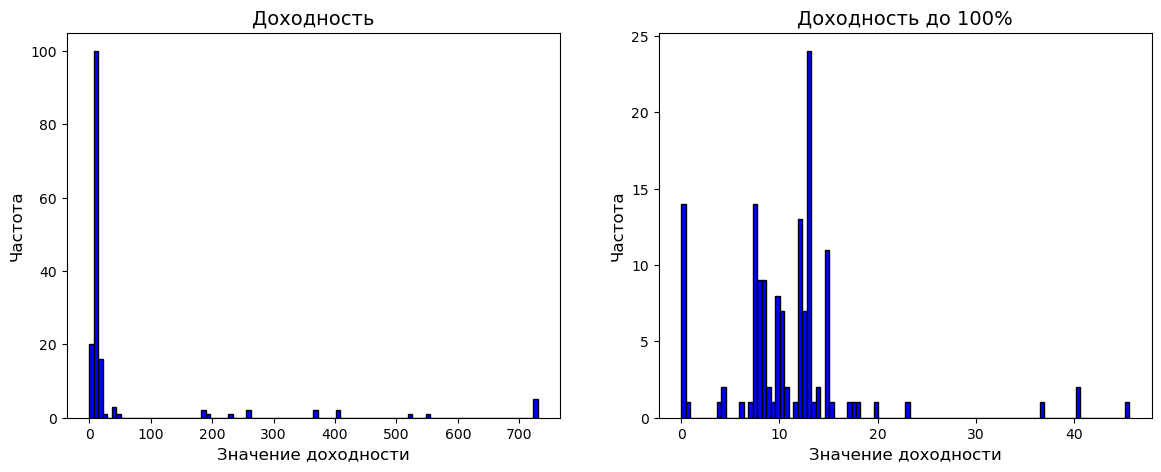

In [9]:
# Посмотрим на распределение нашей целевой переменной в целом и с ограничением в 100 процентов

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(df['Доходность'], 100, color='blue', edgecolor='black');
axs[0].set_title('Доходность', fontsize=14);
axs[0].set_xlabel('Значение доходности', fontsize=12);
axs[0].set_ylabel('Частота', fontsize=12);

axs[1].hist(df[df['Доходность'] < 100]['Доходность'], 100, color='blue', edgecolor='black');
axs[1].set_title('Доходность до 100%', fontsize=14);
axs[1].set_xlabel('Значение доходности', fontsize=12);
axs[1].set_ylabel('Частота', fontsize=12);

Заметим, что подавляющее большинство значений лежит в разумных пределах (около 10 процентов), однако некоторые выпуски показывают сверх высокие доходности.

Text(0, 0.5, 'Частота')

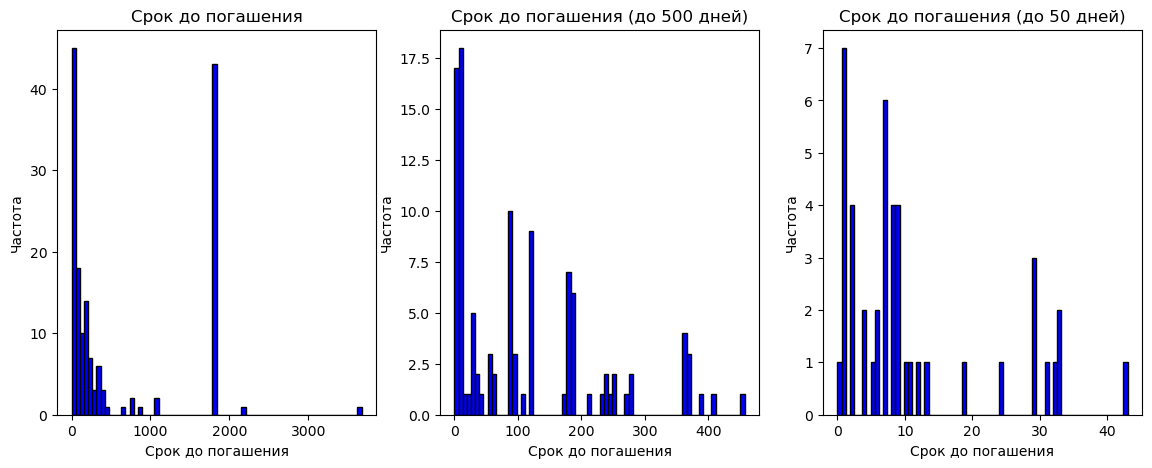

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

axs[0].hist(df['Срок до погашения'], color='blue', bins=70, edgecolor='black')
axs[0].set_title('Срок до погашения')
axs[0].set_xlabel('Срок до погашения')
axs[0].set_ylabel('Частота')

axs[1].hist(df[df['Срок до погашения'] < 500]['Срок до погашения'], color='blue', bins=70, edgecolor='black')
axs[1].set_title('Срок до погашения (до 500 дней)')
axs[1].set_xlabel('Срок до погашения')
axs[1].set_ylabel('Частота')

axs[2].hist(df[df['Срок до погашения'] < 50]['Срок до погашения'], color='blue', bins=70, edgecolor='black')
axs[2].set_title('Срок до погашения (до 50 дней)')
axs[2].set_xlabel('Срок до погашения')
axs[2].set_ylabel('Частота')

In [11]:
# проверим откуда взялся резкий скачок на первой гистаграмме
df['Срок до погашения'].value_counts().head()

1832.0    12
1827.0    12
1828.0    11
1.0        7
7.0        6
Name: Срок до погашения, dtype: int64

In [12]:
# Посмотрим кто выпускал ЦФА с таким сроком до погашения
print('1832 дня до погашения:', df[df['Срок до погашения'] == 1832]['Оператор ЦФА'].unique()[0])
print('1827 дней до погашения:', df[df['Срок до погашения'] == 1827]['Оператор ЦФА'].unique()[0])
print('1828 дней до погашения:', df[df['Срок до погашения'] == 1828]['Оператор ЦФА'].unique()[0])

1832 дня до погашения: ООО «Атомайз»
1827 дней до погашения: ООО «Атомайз»
1828 дней до погашения: ООО «Атомайз»


Из графиков видно, что большинство ЦФА выпскаются меньше чем на 1000 дней (меньше трех лет). Однако на первой гистрограмме наблюдается сильный рост выпусков с сроком до погашения около 1800 дней (Примерно 5 лет), это заслуга эмитента ООО «Атомайз», который совершил более 30 пятилетних выпусков

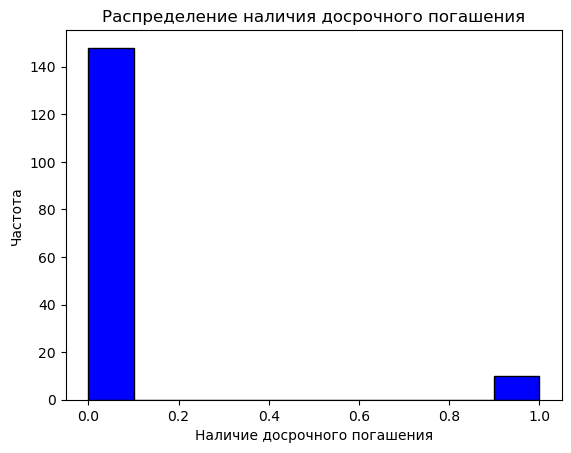

In [13]:
# Посмотрим на нашу бинарную переменную
plt.hist(df['Наличие досрочного погашения'], color = 'blue', edgecolor='black');

plt.xlabel('Наличие досрочного погашения')
plt.ylabel('Частота')
plt.title('Распределение наличия досрочного погашения');

In [14]:
df['Наличие досрочного погашения'].mean()

0.06329113924050633

Большинство выпусков ЦФА не подразумевают досрочное погашение

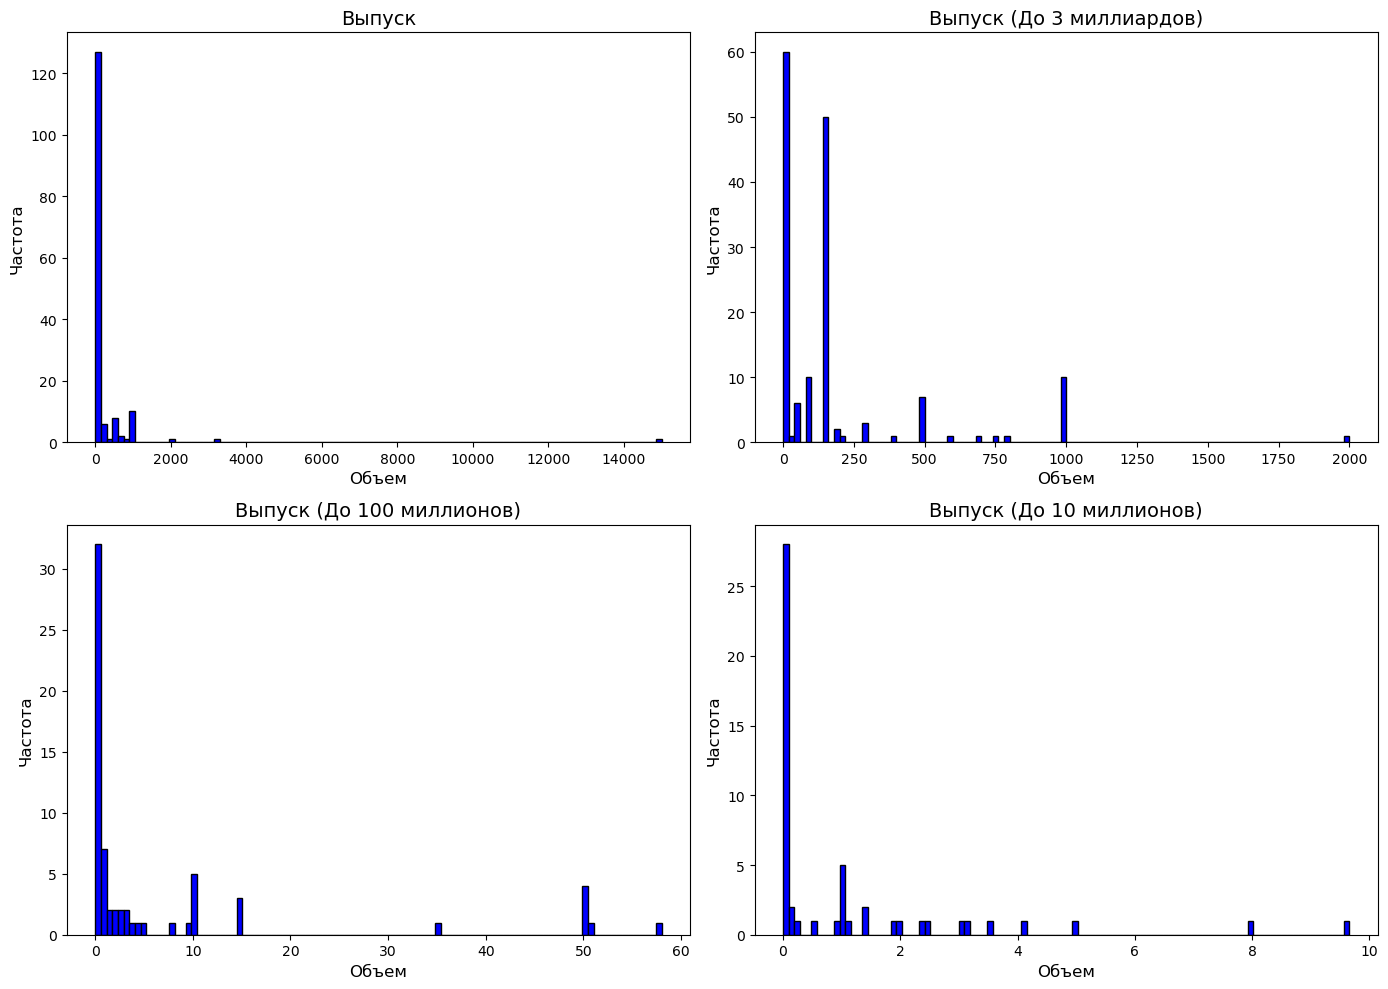

In [15]:
# Посмотрим на распределение объема выпуска (в млн рублей)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].hist(df['Объем выпуска'], 100, color='blue', edgecolor='black')
axs[0, 0].set_title('Выпуск', fontsize=14)
axs[0, 0].set_xlabel('Объем', fontsize=12)
axs[0, 0].set_ylabel('Частота', fontsize=12)

axs[0, 1].hist(df[df['Объем выпуска'] < 3000]['Объем выпуска'], 100, color='blue', edgecolor='black')
axs[0, 1].set_title('Выпуск (До 3 миллиардов)', fontsize=14)
axs[0, 1].set_xlabel('Объем', fontsize=12)
axs[0, 1].set_ylabel('Частота', fontsize=12)

axs[1, 0].hist(df[df['Объем выпуска'] < 100]['Объем выпуска'], 100, color='blue', edgecolor='black')
axs[1, 0].set_title('Выпуск (До 100 миллионов)', fontsize=14)
axs[1, 0].set_xlabel('Объем', fontsize=12)
axs[1, 0].set_ylabel('Частота', fontsize=12)

axs[1, 1].hist(df[df['Объем выпуска'] < 10]['Объем выпуска'], 100, color='blue', edgecolor='black')
axs[1, 1].set_title('Выпуск (До 10 миллионов)', fontsize=14)
axs[1, 1].set_xlabel('Объем', fontsize=12)
axs[1, 1].set_ylabel('Частота', fontsize=12)

plt.tight_layout()

In [16]:
df[df['Объем выпуска'] > 10000]

,Оператор ЦФА,Дата сделки,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность
40,ООО «Системы\nраспределенного реестра»,2023-06-15,7.5,15000.0,181.0,0.0,8.45


Заметно, что большая часть выпусков ЦФА по объему не превышает один миллиард рублей, однако бывают и заметные исключения, например 15 июня был совершен выпуск на 15000 миллиардов

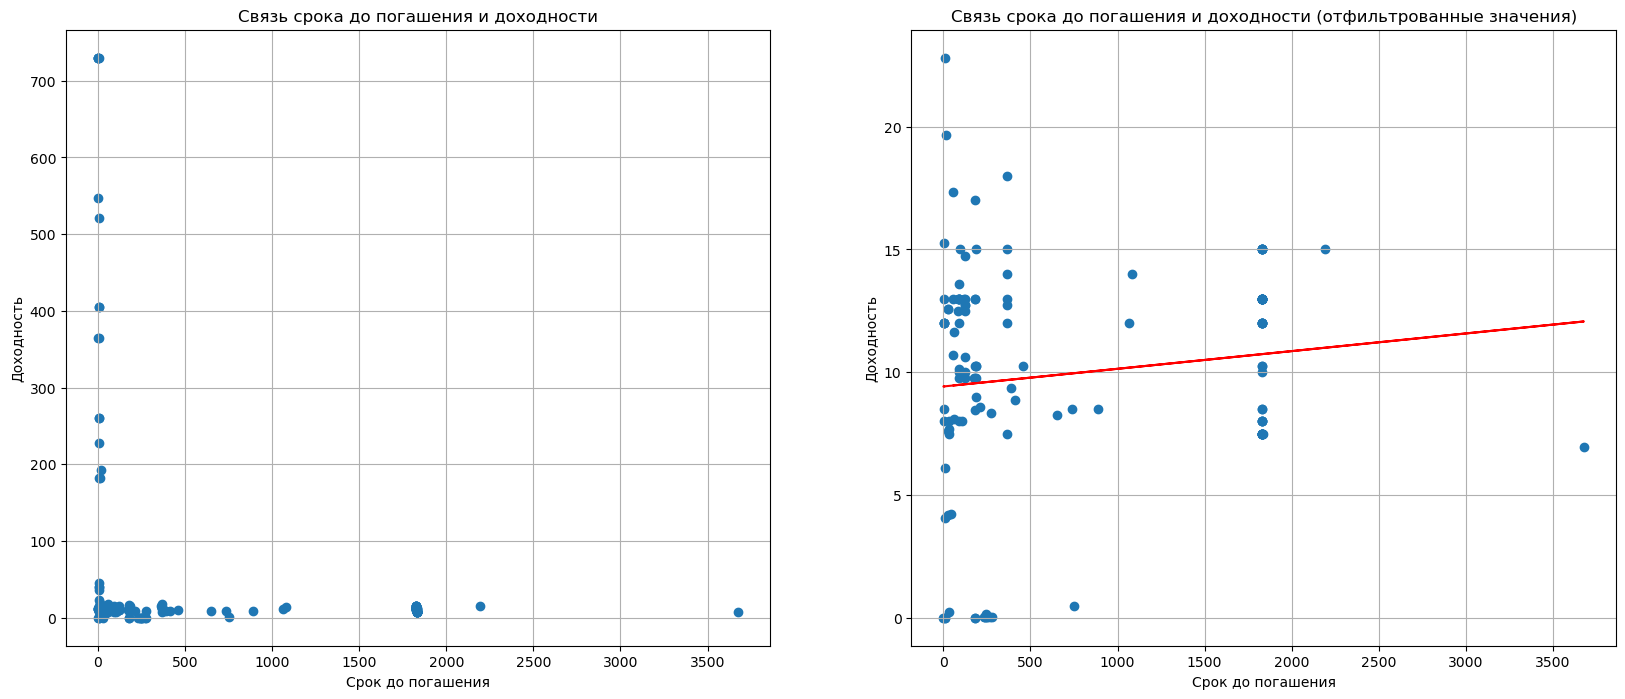

In [17]:
# Посмотрим на связь срока до погашения и доходности ЦФА
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].scatter(df['Срок до погашения'], df['Доходность'])
axs[0].set_title('Связь срока до погашения и доходности')
axs[0].set_xlabel('Срок до погашения')
axs[0].set_ylabel('Доходность')

filtered_df = df[df['Доходность'] < 30]
x = filtered_df['Срок до погашения']
y = filtered_df['Доходность']
m, b = np.polyfit(x, y, 1)
axs[1].scatter(x, y)
axs[1].plot(x, m * x + b, color = 'red')
axs[1].set_title('Связь срока до погашения и доходности (отфильтрованные значения)')
axs[1].set_xlabel('Срок до погашения')
axs[1].set_ylabel('Доходность')

axs[0].grid(True)
axs[1].grid(True)

На первой диаграмме из-за обилия выбросов сложно уловить какую либо зависимость, однако если мы ограничим доходность 30 процентами, то станет заметна некая свзяь. Видно, что с повышением срока до погашения в среднем доходность падает немного возрастает

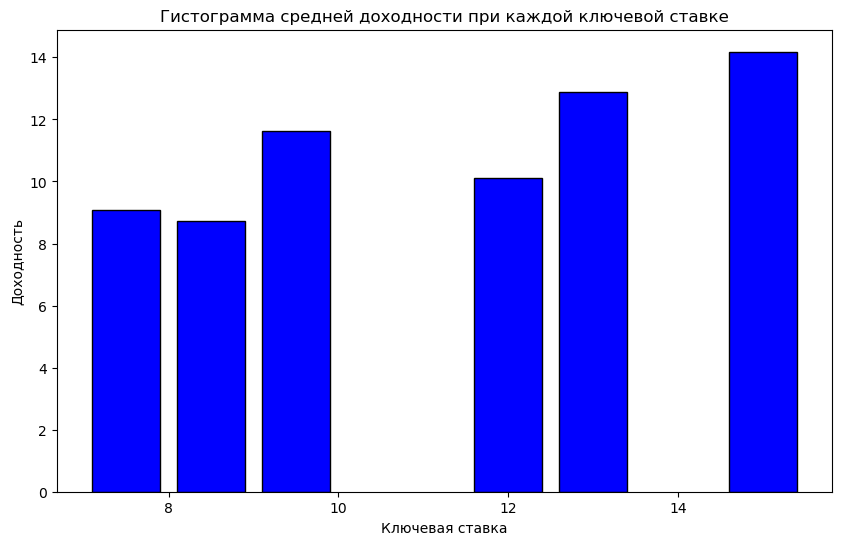

In [18]:
# Посмотрим на значения средней доходности при каждом значении ключевой ставки
mean_volume = df[df['Доходность'] < 100].groupby('Ключ')['Доходность'].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_volume.index, mean_volume.values, color='blue', edgecolor='black')
plt.xlabel('Ключевая ставка')
plt.ylabel('Доходность')
plt.title('Гистограмма средней доходности при каждой ключевой ставке');

In [19]:
pd.DataFrame(mean_volume)

,Доходность
Ключ,
7.5,9.075200
8.5,8.716154
9.5,11.640000
12.0,10.117083
13.0,12.894444
15.0,14.182353


Посмотрим на зависимость доходностей ЦФА и их оператора

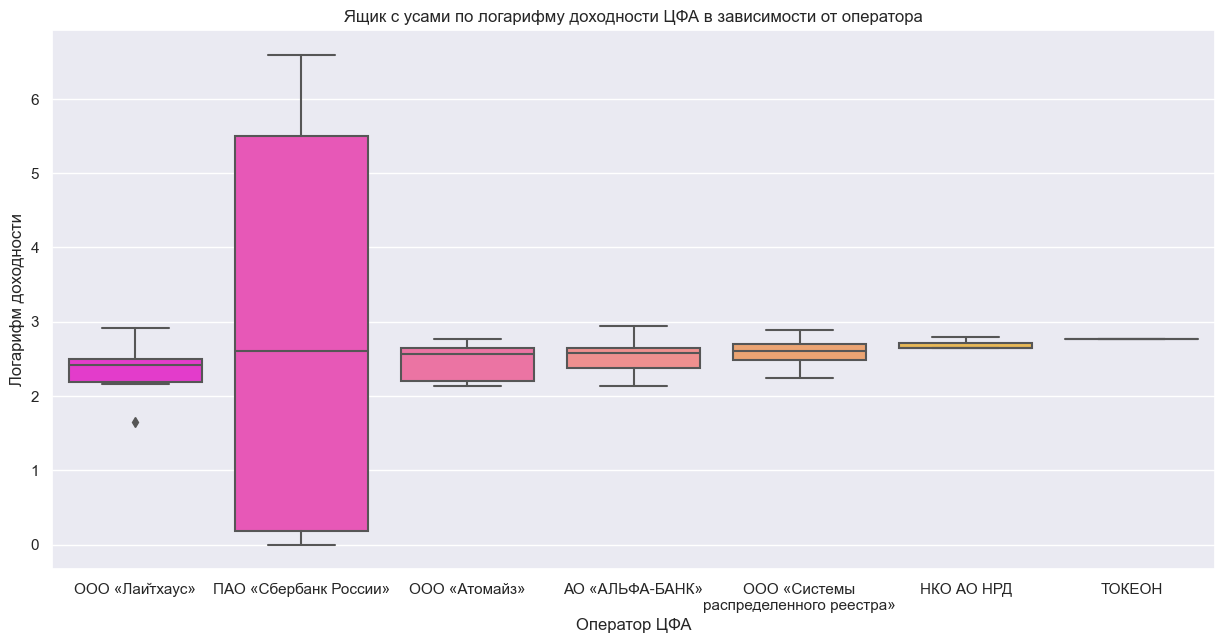

In [20]:
log_df = df
log_df['Доходность'] = np.log1p(df['Доходность'])

sns.set(rc={"figure.figsize":(15, 7)})
plt.xticks(rotation=0)

sns.boxplot(data=log_df, 
			x='Оператор ЦФА', 
			y='Доходность', 
			palette='spring').\
				set(title='Ящик с усами по логарифму доходности ЦФА в зависимости от оператора',
		 		xlabel='Оператор ЦФА',
				ylabel='Логарифм доходности');

Вполне ожидаемый результат, с повышением ключевой ставки доходность также возрастает

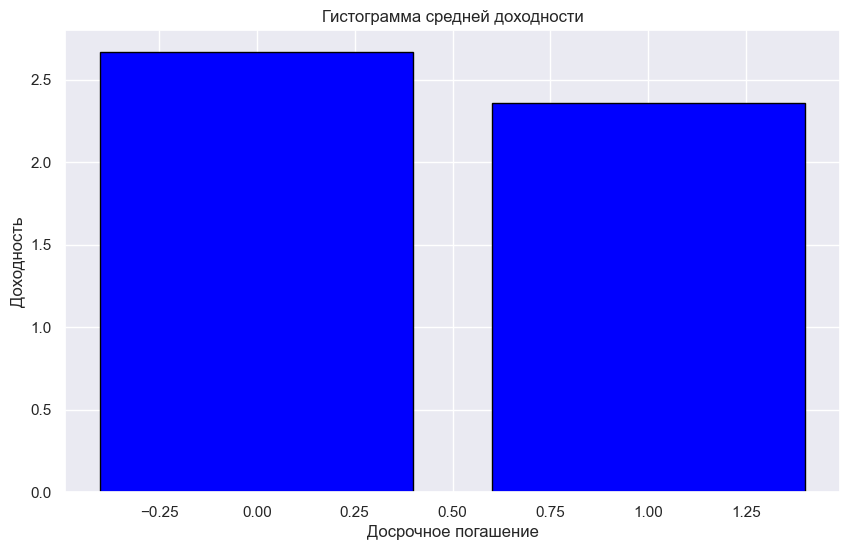

In [21]:
mean_val = df[df['Доходность'] < 100].groupby('Наличие досрочного погашения')['Доходность'].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_val.index, mean_val.values, color='blue', edgecolor='black')
plt.xlabel('Досрочное погашение')
plt.ylabel('Доходность')
plt.title('Гистограмма средней доходности');

In [22]:
pd.DataFrame(mean_val)

,Доходность
Наличие досрочного погашения,
0.0,2.665675
1.0,2.359058


In [23]:
# Теперь посмотрим на корреляции между нашими переменными
df.iloc[:, 1:].corr()

,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность
Ключ,1.000000,0.009311,0.277264,-0.065753,-0.035282
Объем выпуска,0.009311,1.000000,-0.071478,-0.049534,-0.042124
Срок до погашения,0.277264,-0.071478,1.000000,-0.060408,-0.148571
Наличие досрочного погашения,-0.065753,-0.049534,-0.060408,1.000000,-0.053222
Доходность,-0.035282,-0.042124,-0.148571,-0.053222,1.000000


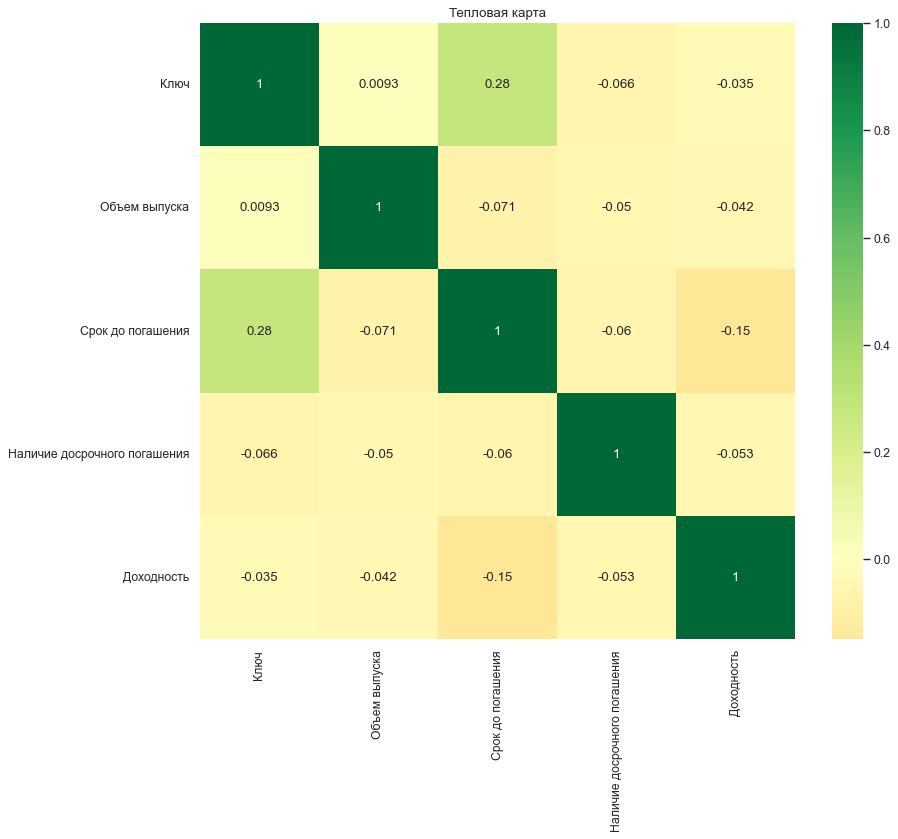

In [24]:
plt.figure(figsize = (12,10), dpi= 80)
sns.heatmap(df.iloc[:, 2:].corr(), xticklabels = df.iloc[:, 2:].corr().columns, 
            yticklabels = df.iloc[:, 2:].corr().columns, cmap = 'RdYlGn', center = 0, annot = True);
plt.title('Тепловая карта');

In [25]:
# В данных довольно много маленьких выпусков, побробуем ограничить минимальный размер выпуска до 1 миллиона
df[df['Объем выпуска'] > 1].iloc[:, 1:].corr()

,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность
Ключ,1.000000,-0.064558,0.110623,-0.158677,0.560288
Объем выпуска,-0.064558,1.000000,-0.141055,-0.070978,0.036845
Срок до погашения,0.110623,-0.141055,1.000000,-0.133199,0.145792
Наличие досрочного погашения,-0.158677,-0.070978,-0.133199,1.000000,0.017438
Доходность,0.560288,0.036845,0.145792,0.017438,1.000000


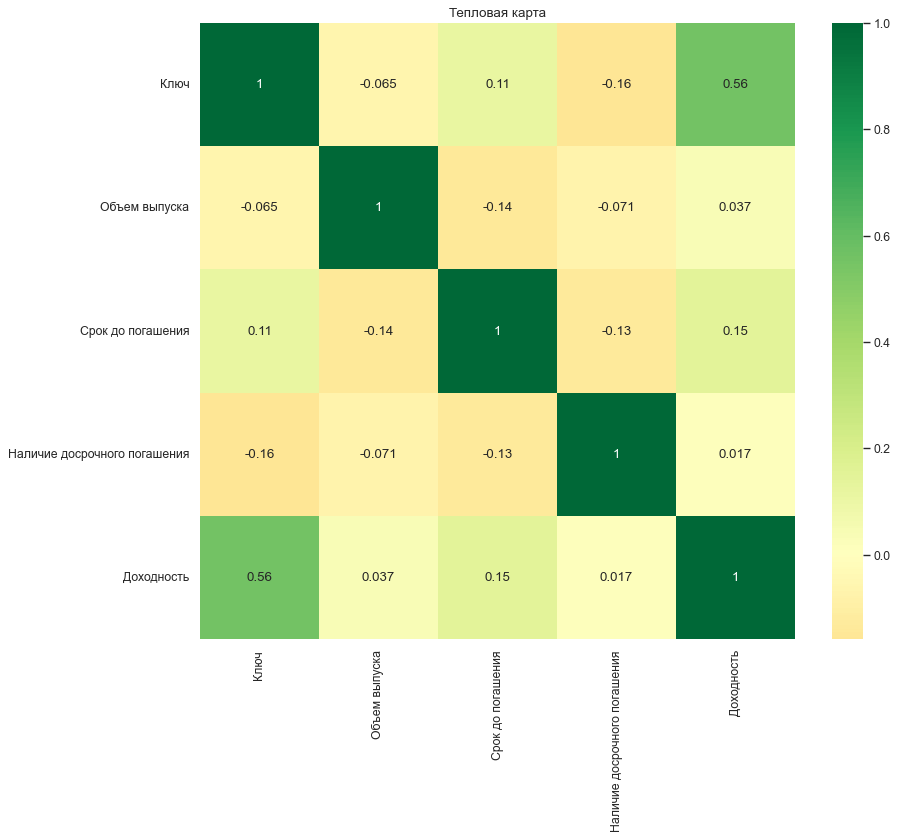

In [26]:
df_filt = df[df['Объем выпуска'] > 1]

plt.figure(figsize = (12,10), dpi= 80)
sns.heatmap(df_filt.iloc[:, 2:].corr(), xticklabels = df_filt.iloc[:, 2:].corr().columns, 
            yticklabels = df_filt.iloc[:, 2:].corr().columns, cmap = 'RdYlGn', center = 0, annot = True);
plt.title('Тепловая карта');

# Построение модели

In [27]:
# from sklearn.linear_model import LinearRegression Она нам не понадобится, тут лучше использовать stats
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

In [28]:
ohe = OneHotEncoder()
data_new = ohe.fit_transform(df[['Оператор ЦФА']])
df[ohe.categories_[0]] = data_new.toarray()
df

,Оператор ЦФА,Дата сделки,Ключ,Объем выпуска,Срок до погашения,Наличие досрочного погашения,Доходность,АО «АЛЬФА-БАНК»,НКО АО НРД,ООО «Атомайз»,ООО «Лайтхаус»,ООО «Системы\nраспределенного реестра»,ПАО «Сбербанк России»,ТОКЕОН
0,ООО «Лайтхаус»,2022-06-28,9.5,5.00,59.0,1.0,2.536866,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ПАО «Сбербанк России»,2022-09-21,7.5,9.66,90.0,0.0,2.681022,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ООО «Лайтхаус»,2022-10-20,7.5,100.00,56.0,0.0,2.458734,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,ООО «Лайтхаус»,2022-10-21,7.5,50.00,59.0,1.0,2.208274,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ПАО «Сбербанк России»,2022-11-17,7.5,1.00,43.0,0.0,1.656321,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,АО «АЛЬФА-БАНК»,2023-11-10,15.0,100.00,94.0,0.0,2.772589,1.0,0.0,0.0,0.0,0.0,0.0,0.0
154,ТОКЕОН,2023-11-18,15.0,3.50,363.0,0.0,2.772589,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155,ООО «Системы\nраспределенного реестра»,2023-12-28,15.0,146.00,1064.0,0.0,2.564949,0.0,0.0,0.0,0.0,1.0,0.0,0.0
156,АО «АЛЬФА-БАНК»,2023-06-30,15.0,10.10,91.0,0.0,2.197225,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
ohe.categories_

[array(['АО «АЛЬФА-БАНК»', 'НКО АО НРД', 'ООО «Атомайз»',
        'ООО «Лайтхаус»', 'ООО «Системы\nраспределенного реестра»',
        'ПАО «Сбербанк России»', 'ТОКЕОН'], dtype=object)]

In [30]:
df[ohe.categories_[0]].sum()

АО «АЛЬФА-БАНК»                           36.0
НКО АО НРД                                 3.0
ООО «Атомайз»                             56.0
ООО «Лайтхаус»                            7.0
ООО «Системы\nраспределенного реестра»     4.0
ПАО «Сбербанк России»                     51.0
ТОКЕОН                                     1.0
dtype: float64

In [31]:
# Мы не используем одну dummy переменную (ТОКЕОН), чтобы избежать зависимости с константой

X = df.drop(columns=['Оператор ЦФА', 'Дата сделки', 'Доходность', 'ТОКЕОН'])
y = df['Доходность']

In [32]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Доходность   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.8254
Date:                Sun, 10 Dec 2023   Prob (F-statistic):              0.605
Time:                        22:26:05   Log-Likelihood:                -273.35
No. Observations:                 158   AIC:                             568.7
Df Residuals:                     147   BIC:                             602.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     2.0490      1.609      1.273      0.205      -1.131       5.229
Ключ                                      0.0566      0.052      1.088      0.278      -0.046       0.159
Объем выпуска                         -1.846e-05      0.000     -0.173      0.863      -0.000       0.000
Срок до погашения                        -0.0003      0.000     -1.613      0.109      -0.001    7.76e-05
Наличие досрочного погашения             -0.1211      0.576     -0.210      0.834      -1.260       1.018
АО «АЛЬФА-БАНК»                          -0.1447      1.442     -0.100      0.920      -2.994       2.705
НКО АО НРД                                0.0178      1.645      0.011      0.991      -3.234       3.270
ООО «Атомайз»                             0.2804      1.469      0.191      0.849      -2.622       3.183
ООО «Лайтхаус»                          -0.1089      1.593     -0.068      0.946      -3.256       3.038
ООО «Системы
распределенного реестра»     0.0584      1.633      0.036      0.972      -3.170       3.286
ПАО «Сбербанк России»                     0.5649      1.471      0.384      0.702      -2.342       3.472
==============================================================================
Omnibus:                       10.440   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               21.152
Skew:                           0.204   Prob(JB):                     2.55e-05
Kurtosis:                       4.746   Cond. No.                     4.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как мы можем заметить, у наших данных есть большая проблема в виде отсутсвия значимости почти у всех коэффициентов модели...

Чтож, попробуем это исправить с помощью логарифмирования, но если и оно не поможет, придётся урезать и без того малый набор данных по выбросам целевой переменной

In [33]:
X[['Ключ', 'Объем выпуска', 'Срок до погашения']] = np.log1p(X[['Ключ', 'Объем выпуска', 'Срок до погашения']])
y = np.log1p(y)

In [34]:
log_model = sm.OLS(y, X).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Доходность   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2.718
Date:                Sun, 10 Dec 2023   Prob (F-statistic):            0.00431
Time:                        22:26:05   Log-Likelihood:                -81.039
No. Observations:                 158   AIC:                             184.1
Df Residuals:                     147   BIC:                             217.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.1037      0.634      1.741      0.084      -0.149       2.357
Ключ                                      0.2839      0.171      1.657      0.100      -0.055       0.623
Объем выпуска                            -0.0060      0.027     -0.223      0.824      -0.059       0.047
Срок до погашения                        -0.0939      0.020     -4.586      0.000      -0.134      -0.053
Наличие досрочного погашения             -0.0012      0.177     -0.007      0.995      -0.350       0.348
АО «АЛЬФА-БАНК»                          -0.0642      0.445     -0.144      0.885      -0.944       0.815
НКО АО НРД                               -0.2715      0.506     -0.537      0.592      -1.271       0.728
ООО «Атомайз»                             0.0745      0.436      0.171      0.865      -0.788       0.937
ООО «Лайтхаус»                          -0.1498      0.490     -0.306      0.760      -1.118       0.818
ООО «Системы
распределенного реестра»     0.0038      0.477      0.008      0.994      -0.939       0.946
ПАО «Сбербанк России»                    -0.2625      0.436     -0.603      0.548      -1.123       0.598
==============================================================================
Omnibus:                       34.996   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.813
Skew:                          -1.092   Prob(JB):                     1.69e-13
Kurtosis:                       5.041   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Малое примечание:** как мы видим, теперь срок до погашения стал значимым, что в принципе не удивительно, ведь в нашей выборке присутствует немало наблюдений с малым сроком погашения и огромной доходностью, большую часть из которых выпустил сбер (напоминает микрозаймы). К сожалению мы ещё не проходили стандартизацию, как метод по улучшению модели на метрике, но возможно она бы смогла пролить свет на значимость ключа в модели.

<h4> Модель без выбросов </h4>

In [35]:
df_30 = df.loc[df['Доходность'] < 30]

In [36]:
# Сбера стало намного меньше

df_30[ohe.categories_[0]].sum()

АО «АЛЬФА-БАНК»                           36.0
НКО АО НРД                                 3.0
ООО «Атомайз»                             56.0
ООО «Лайтхаус»                            7.0
ООО «Системы\nраспределенного реестра»     4.0
ПАО «Сбербанк России»                     51.0
ТОКЕОН                                     1.0
dtype: float64

In [37]:
X_30 = df_30.drop(columns=['Оператор ЦФА', 'Дата сделки', 'Доходность', 'ООО «Лайтхаус»'])
y_30 = df_30['Доходность']

X_30[['Ключ', 'Объем выпуска', 'Срок до погашения']] = np.log1p(X_30[['Ключ', 'Объем выпуска', 'Срок до погашения']])
y_30 = np.log1p(y_30)

In [38]:
X_30 = sm.add_constant(X_30)
log_model_30 = sm.OLS(y_30, X_30).fit()

log_model_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Доходность   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2.718
Date:                Sun, 10 Dec 2023   Prob (F-statistic):            0.00431
Time:                        22:26:05   Log-Likelihood:                -81.039
No. Observations:                 158   AIC:                             184.1
Df Residuals:                     147   BIC:                             217.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.9539      0.443      2.153      0.033       0.078       1.829
Ключ                                      0.2839      0.171      1.657      0.100      -0.055       0.623
Объем выпуска                            -0.0060      0.027     -0.223      0.824      -0.059       0.047
Срок до погашения                        -0.0939      0.020     -4.586      0.000      -0.134      -0.053
Наличие досрочного погашения             -0.0012      0.177     -0.007      0.995      -0.350       0.348
АО «АЛЬФА-БАНК»                           0.0856      0.214      0.400      0.690      -0.338       0.509
НКО АО НРД                               -0.1217      0.317     -0.384      0.702      -0.748       0.505
ООО «Атомайз»                             0.2243      0.212      1.058      0.292      -0.195       0.643
ООО «Системы
распределенного реестра»     0.1536      0.298      0.515      0.607      -0.435       0.743
ПАО «Сбербанк России»                    -0.1127      0.242     -0.465      0.643      -0.591       0.366
ТОКЕОН                                    0.1498      0.490      0.306      0.760      -0.818       1.118
==============================================================================
Omnibus:                       34.996   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.813
Skew:                          -1.092   Prob(JB):                     1.69e-13
Kurtosis:                       5.041   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Малое примечание:** Теперь мы можем сказать, что при отсутствии выбросов в модели, ключевая ставка значима и её можно интерпретировать, также стало заметно, что теперь влияние сбера стало значимым, ну и срок до погашения свою значимость утратил

Кажется, что при большем объёме данных, мы бы смогли интерпретировать большее количество коэффициентов, но имеем, что имеем



<center>

<h2> На этом раздел программирования заканчивается </h2>

<img src="https://i.gifer.com/embedded/download/Y92H.gif" style="width: 400px">

</center>